Typical run times:
 * GPU (V100): 15s per epoch
 * TPU v3-8 (8 cores): 5s per epoch
 * TPU pod v2-32 (32 cores): 2s per epoch

## Imports

In [2]:
import re
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.1.0-dev20191029


## TPU or GPU detection
TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
platforms: Colaboratory, AI Platform (ML Engine), Kubernetes and Deep Learning
VMs provided the TPU_NAME environment variable is set on the VM.

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['192.168.30.2:8470']
INFO:tensorflow:Initializing the TPU system: martin-tpu-nightly


INFO:tensorflow:Initializing the TPU system: martin-tpu-nightly


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Configuration

Learning rate schedule:


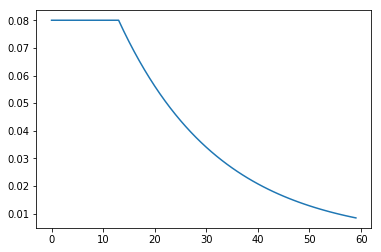

In [3]:
EPOCHS = 60

if strategy.num_replicas_in_sync == 1: # GPU
    # This achieves 80% accuracy on a GPU (final loss 0.45)
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.01
    max_lr = 0.01
    min_lr = 0.01
    rampup_epochs = 0
    sustain_epochs = 0
    exp_decay = 1
    
elif strategy.num_replicas_in_sync == 8: # single TPU
    # This achieves 80% accuracy on a TPU v3-8 (final loss 0.44)
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 256
    start_lr = 0.01
    max_lr = 0.01 * strategy.num_replicas_in_sync
    min_lr = 0.001
    rampup_epochs = 0
    sustain_epochs = 13
    exp_decay = .95

else: # TPU pod
    # This achieves 80% accuracy on a TPU v2-32 pod (final loss 0.54)
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync  # Gobal batch size.
    VALIDATION_BATCH_SIZE = 256
    start_lr = 0.06
    max_lr = 0.012 * strategy.num_replicas_in_sync
    min_lr = 0.01
    rampup_epochs = 5
    sustain_epochs = 8
    exp_decay = 0.95

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

IMAGE_SIZE = [331, 331] # supported images sizes: 192x192, 331x331, 512,512
                        # make sure you load the appropriate dataset on the next line
#GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
#GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
VALIDATION_SPLIT = 0.19

# Learning rate schedule
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

print("Learning rate schedule:")
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
plt.show()

In [4]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def count_data_items(filenames):
    # trick: the number of data items is written in the name of
    # the .tfrec files a flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # force the image size so that the shape of the tensor is known to Tensorflow
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use TFRecordDataset with
    # num_parallel_calls=AUTOTUNE to read from multiple TFRecord files at once
    # band set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames).with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16) # can be AUTOTUNE in TF 2.1
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def batch_dataset(filenames, batch_size, train):
    dataset = load_dataset(filenames)
    n = count_data_items(filenames)
    
    if train:
        dataset = dataset.repeat() # training dataset must repeat
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(2048)
    else:
        # usually fewer validation files than workers so disable FILE auto-sharding on validation
        if strategy.num_replicas_in_sync > 1: # option not useful if there is no sharding (not harmful either)
            opt = tf.data.Options()
            opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
            dataset = dataset.with_options(opt)
        # validation dataset does not need to repeat
        # also no need to shuffle or apply data augmentation
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset, n//batch_size

def get_training_dataset(filenames):
    dataset, steps = batch_dataset(filenames, BATCH_SIZE, train=True)
    return dataset, steps

def get_validation_dataset(filenames):
    dataset, steps = batch_dataset(filenames, VALIDATION_BATCH_SIZE, train=False)
    return dataset, steps

In [6]:
# instantiate datasets
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = len(filenames) - int(len(filenames) * VALIDATION_SPLIT)
train_filenames = filenames[:split]
valid_filenames = filenames[split:]

training_dataset, steps_per_epoch = get_training_dataset(train_filenames)
validation_dataset, validation_steps = get_validation_dataset(valid_filenames)

print("TRAINING   IMAGES: ", count_data_items(train_filenames), ", STEPS PER EPOCH: ", steps_per_epoch)
print("VALIDATION IMAGES: ", count_data_items(valid_filenames), ", STEPS PER EPOCH: ", validation_steps)

# numpy data to test predictions
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(valid_filenames), 160)

TRAINING   IMAGES:  2990 , STEPS PER EPOCH:  11
VALIDATION IMAGES:  680 , STEPS PER EPOCH:  2


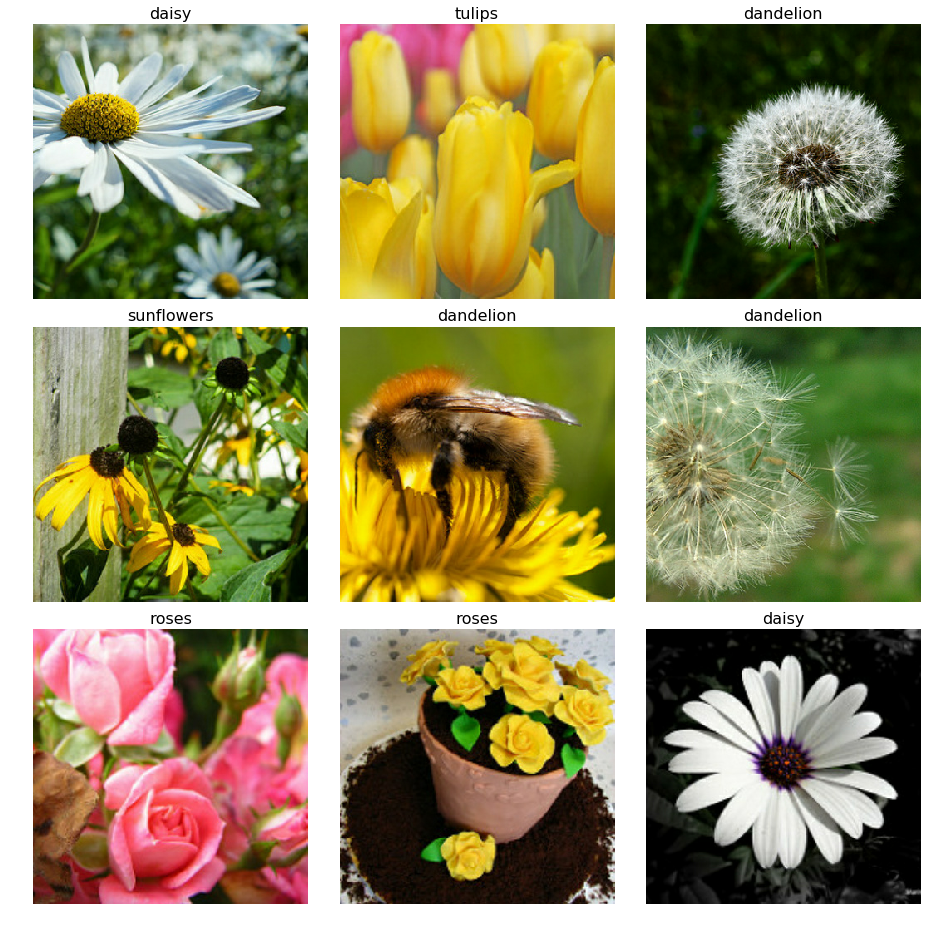

In [7]:
display_9_images_from_dataset(load_dataset(train_filenames))

## The model: squeezenet with 12 layers

In [8]:
def create_model():
    bnmomemtum=0.9 # with only a handful of batches per epoch, the batch norm running average period must be lowered
    def fire(x, squeeze, expand):
        y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation=None, padding='same', use_bias=False)(x)
        y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum, scale=False, center=True)(y)
        y = tf.keras.layers.Activation('relu')(y)
        y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation=None, padding='same', use_bias=False)(y)
        y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum, scale=False, center=True)(y1)
        y1 = tf.keras.layers.Activation('relu')(y1)
        y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation=None, padding='same', use_bias=False)(y)
        y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum, scale=False, center=True)(y3)
        y3 = tf.keras.layers.Activation('relu')(y3)
        return tf.keras.layers.concatenate([y1, y3])

    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    x = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3)) # input is 331x331 pixels RGB
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(48, 96)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(64, 128)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(48, 96)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Dense(5, activation='softmax')(y)
    return tf.keras.Model(x, y)

## Instantiate the model

In [9]:
with strategy.scope():
    model = create_model()
    
    model.compile(optimizer=tf.keras.optimizers.SGD(nesterov=True, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 331, 331, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 331, 331, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 331, 331, 24) 768         batch_normalization[0][0]        
______________________________________________________________________________________________

## Training

In [10]:
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Train for 11 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.08.
Epoch 1/60
11/11 [==============================] - 41s 4s/step - loss: 1.5309 - accuracy: 0.3377 - val_loss: 1.6670 - val_accuracy: 0.2471

Epoch 00002: LearningRateScheduler reducing learning rate to 0.08.
Epoch 2/60
11/11 [==============================] - 5s 443ms/step - loss: 1.3051 - accuracy: 0.4748 - val_loss: 1.6256 - val_accuracy: 0.3059

Epoch 00003: LearningRateScheduler reducing learning rate to 0.08.
Epoch 3/60
11/11 [==============================] - 5s 433ms/step - loss: 1.1993 - accuracy: 0.5078 - val_loss: 1.2215 - val_accuracy: 0.4956

Epoch 00004: LearningRateScheduler reducing learning rate to 0.08.
Epoch 4/60
11/11 [==============================] - 5s 453ms/step - loss: 1.1245 - accuracy: 0.5572 - val_loss: 1.0812 - val_accuracy: 0.5500

Epoch 00005: LearningRateScheduler reducing learning rate to 0.08.
Epoch 5/60
11/11 [==============================] - 5s 434ms/step - loss: 1

dict_keys(['val_loss', 'lr', 'accuracy', 'loss', 'val_accuracy'])


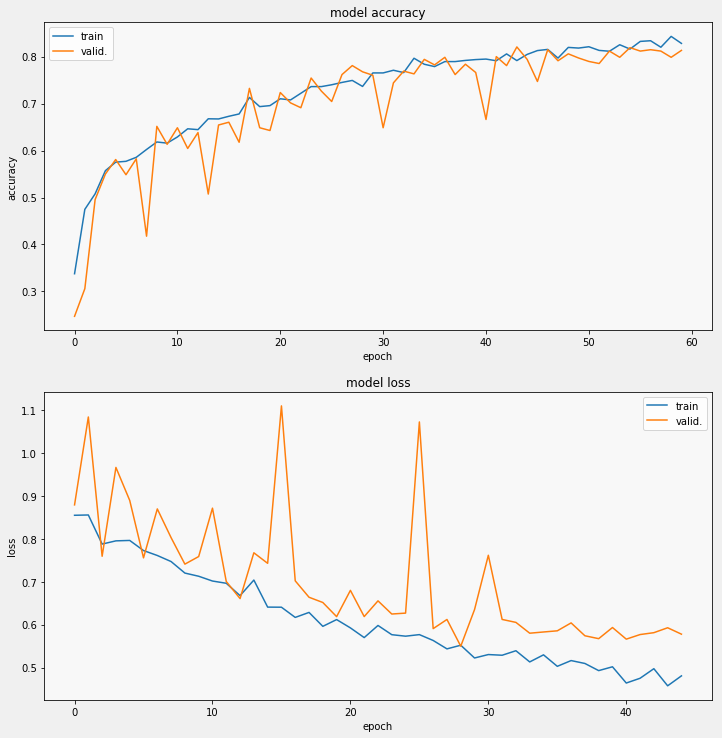

In [11]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'][15:], history.history['val_loss'][15:], 'loss', 212)

## Predictions

In [16]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16, verbose=0) # Little wrinkle: eval progress bar broken inb this version of TF 2.0 preview
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

['sunflowers', 'tulips', 'roses', 'daisy', 'tulips', 'tulips', 'daisy', 'daisy', 'sunflowers', 'tulips', 'dandelion', 'daisy', 'roses', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'tulips', 'roses', 'sunflowers', 'tulips', 'dandelion', 'daisy', 'roses', 'tulips', 'dandelion', 'dandelion', 'tulips', 'roses', 'dandelion', 'tulips', 'roses', 'daisy', 'daisy', 'sunflowers', 'roses', 'roses', 'daisy', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'dandelion', 'roses', 'daisy', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'daisy', 'daisy', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'sunflowers', 'daisy', 'daisy', 'dandelion', 'tulips', 'dandelion', 'tulips', 'tulips', 'roses', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'daisy', 'daisy', 'roses', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'roses', 'dandelion', 'roses', 'roses', 'daisy', 'dandelion', 'dandelion', 'roses', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'dand

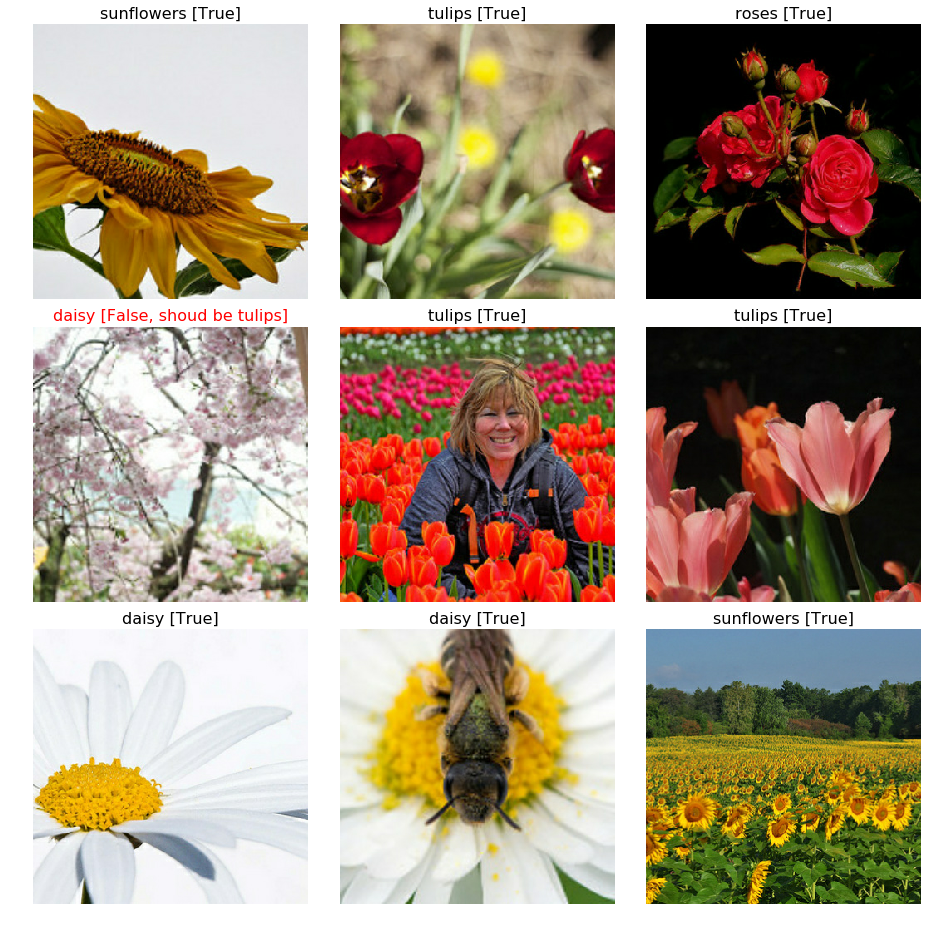

In [17]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
